In [1]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np
import matplotlib.pyplot as plt

from mihm.data.process import multi_cat_to_one_hot, binary_to_one_hot, standardize_continuous_cols, convert_categorical_to_ordinal
from mihm.data.trainutils import train_test_split
from mihm.model.mihm import MIHM, IndexPredictionModel
from mihm.model.mihm_dataset import MIHMDataset
from mihm.model.modelutils import get_index_prediction_weights

In [2]:
read_cols = ["zPCPhenoAge_acc", "m_HeatIndex_7d", "age2016", "female", "racethn", "eduy", "ihs_wealthf2016", "pmono", "PNK_pct", 
            "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct",
            "smoke2016", "drink2016", "bmi2016", "tractdis", "urban", "mar_cat2", "psyche2016", "stroke2016", "hibpe2016",
            "diabe2016", "hearte2016", "ltactx2016", "mdactx2016", "vgactx2016", "dep2016", "adl2016", 
            "living2016", "division"]

colname_dict = {
    "zPCPhenoAge_acc": "Pheno Age Accel.", 
    "m_HeatIndex_7d": "mean heat index over 7d", 
    "age2016": "age", 
    "female": "female", 
    "racethn": "race/ethnicity", 
    "eduy": "education (in years)", 
    "ihs_wealthf2016": "household wealth (ihs)", 
    "smoke2016": "smoking status", 
    "drink2016": "drinking status", 
    "bmi2016": "bmi", 
    "tractdis": "tract disadvantage", 
    "urban": "urbanicity", 
    "mar_cat2": "marital status", 
    "psyche2016": "psychiatric conditions", 
    "stroke2016": "stroke", 
    "hibpe2016": "hypertension",
    "diabe2016": "diabetes", 
    "hearte2016": "heart disease", 
    "ltactx2016": "light activity", 
    "mdactx2016": "moderate activity", 
    "vgactx2016": "vigorous activity", 
    "dep2016": "depressive symptoms", 
    "adl2016": "adl limitations", 
    "living2016": "living alone", 
    "division": "census division"
}

df = pd.read_stata('../HeatResilience.dta', columns=read_cols)
df.rename(columns=colname_dict, inplace=True)

In [3]:
categorical_cols = ['female', 'race/ethnicity', 'urbanicity', 'marital status', 'psychiatric conditions', 'stroke',
                    'hypertension', 'diabetes', 'heart disease', 'living alone', 'census division']
ordinal_cols = ['smoking status', 'drinking status', 'light activity', 'moderate activity', 'vigorous activity',]
continuous_cols = ['education (in years)', 'household wealth (ihs)', 'age', 'bmi', 
                   'tract disadvantage', 'depressive symptoms', 'adl limitations', 'mean heat index over 7d',
                    'pmono', "PNK_pct", "PBcell_pct", "PCD8_Plus_pct", "PCD4_Plus_pct", "PNCD8_Plus_pct", "Pheno Age Accel."]
for c in categorical_cols:
    df[c] = df[c].astype("category")
binary_cats = [c for c in categorical_cols if df[c].nunique() <=2]
multi_cats = [c for c in categorical_cols if df[c].nunique() > 2]

In [4]:
# Preprocess df for model
df = binary_to_one_hot(df, binary_cats, dtype="category") # convert binary to one hot
df = multi_cat_to_one_hot(df, multi_cats, dtype="category") # convert multi cat to one hot
df = convert_categorical_to_ordinal(df, ordinal_cols) # convert ordinal to ordinal
df_norm, mean_std_dict = standardize_continuous_cols(df, continuous_cols) # standardize continuous cols
df_norm.dropna(inplace=True) # drop Nan rows

In [5]:
controlled_cols = [
    'mean heat index over 7d',
    "pmono",
    "PNK_pct",
    "PBcell_pct",
    "PCD8_Plus_pct",
    "PCD4_Plus_pct",
    "PNCD8_Plus_pct",
]
interaction_predictors = ['female', 'education (in years)', 'household wealth (ihs)', 
'smoking status', 'drinking status', 'bmi', 'tract disadvantage',
'marital status', 'psychiatric conditions', 'stroke', 'hypertension',
'diabetes', 'heart disease', 'light activity', 'moderate activity',
'vigorous activity', 'depressive symptoms', 'adl limitations',
'living alone', 'race/ethnicity_0. NHW', 'race/ethnicity_1. NHB',
'race/ethnicity_2. Hispanic', 'race/ethnicity_3. Others',
'urbanicity_1. urban', 'urbanicity_2. suurban (code 2)',
'urbanicity_3. ex-urban', 'census division_Northeast',
'census division_Midwest', 'census division_South', 'census division_West']

### Prep data for train test split

In [6]:
# interactor
heat_cont_np = df_norm['mean heat index over 7d'].to_numpy()
# controlled vars
controlled_vars_np = df_norm[controlled_cols].to_numpy()
# interaction input vars
interaction_vars_np = df_norm[interaction_predictors].to_numpy()
# dependent var (label)
pheno_epi_np = df_norm["Pheno Age Accel."].to_numpy()

In [7]:
#dim reduction using PCA
k_dim = 28
U, S, V = torch.pca_lowrank(torch.from_numpy(interaction_vars_np), q=k_dim, center=False, niter=10)
V = V.to(torch.float32)
V.requires_grad = False

In [8]:
num_elems, _ = controlled_vars_np.shape
print("number of data points: {}".format(num_elems))

number of data points: 3325


In [9]:
# split to train and test
train_idx, test_idx = train_test_split(num_elems, 0.7)
train_heat_cont = heat_cont_np[train_idx]
train_controlled_vars = controlled_vars_np[train_idx]
train_interaction_vars = interaction_vars_np[train_idx]
train_pheno_epi = pheno_epi_np[train_idx]

test_heat_cont = torch.from_numpy(heat_cont_np[test_idx].astype(np.float32))
test_controlled_vars = torch.from_numpy(controlled_vars_np[test_idx].astype(np.float32))
test_interaction_vars = torch.from_numpy(interaction_vars_np[test_idx].astype(np.float32))
test_pheno_epi = torch.from_numpy(pheno_epi_np[test_idx].astype(np.float32))

In [10]:
# create dataset
train_dataset = MIHMDataset(train_heat_cont, train_controlled_vars, train_interaction_vars, train_pheno_epi)
dataloader = DataLoader(train_dataset, batch_size=500, shuffle=True)

### Train

In [11]:
from pyro.infer.autoguide import AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import AdamW
import pyro
from mihm.model.bayes_mihm import BayesMIHM

In [12]:
interaction_var_size = interaction_vars_np.shape[1]
controlled_var_size = controlled_vars_np.shape[1]
hidden_layer_sizes = [50, 10, 2]
model = BayesMIHM(interaction_var_size, controlled_var_size, hidden_layer_sizes,
                  svd=True, svd_matrix=V, k_dim=k_dim, include_interactor_bias=True, variational_output=True)

In [13]:
guide = AutoMultivariateNormal(model)

In [14]:
optim = AdamW({"lr": 0.0005, "weight_decay": 0.1})
svi = SVI(model, guide, optim, loss=Trace_ELBO())
epochs = 500
mseLoss = nn.MSELoss()
torch.manual_seed(0)

In [15]:
from pyro.infer import Predictive
def summary(samples):
    site_stats = {}
    for k, v in samples.items():
        site_stats[k] = {
            "mean": torch.mean(v, 0),
            "std": torch.std(v, 0),
            "5%": v.kthvalue(int(len(v) * 0.05), dim=0)[0],
            "95%": v.kthvalue(int(len(v) * 0.95), dim=0)[0],
        }
    return site_stats

In [16]:
def get_test_loss(model, test_interaction_vars, test_heat_cont, test_controlled_vars, test_pheno_epi, n_samples=100):
    model.eval()
    predictive = Predictive(model, guide=guide, num_samples=n_samples,
                    return_sites=("obs", "_RETURN"))
    samples = predictive(test_interaction_vars, test_heat_cont, test_controlled_vars,)
    pred_summary = summary(samples)
    predicted_epi = pred_summary["_RETURN"]["mean"]        
    loss_test = mseLoss(predicted_epi, test_pheno_epi)
    return loss_test.item(), pred_summary

In [17]:
for epoch in range(epochs):
    loss = 0
    for batch_idx, sample in enumerate(dataloader):
        print(len(sample["interaction_input_vars"]))
        loss += svi.step(sample["interaction_input_vars"], sample["interactor_var"], sample["controlled_vars"], y=sample["label"])
    loss /= len(dataloader.dataset)
    print(f"Epoch {epoch+1} : loss = {loss}")
    test_loss, _ = get_test_loss(model, test_interaction_vars, test_heat_cont, test_controlled_vars, test_pheno_epi)
    print(f"Test loss: {test_loss}")

500


500
500
500
327


ValueError: Shape mismatch inside plate('index_data') at site predicted_index dim -1, 500 vs 327
                     Trace Shapes:            
                      Param Sites:            
                 layers$$$0.weight  50 28     
                   layers$$$0.bias     50     
                 layers$$$1.weight  10 50     
                   layers$$$1.bias     10     
                 layers$$$2.weight   2 10     
                   layers$$$2.bias      2     
                     Sample Sites:            
controlled_var_weights.weight dist      | 1 37
                             value      | 1 37
  controlled_var_weights.bias dist      | 1   
                             value      | 1   
                   index_data dist      |     
                             value 500  |     

In [ ]:
print("interaction_weight:", model.interaction_weight)

interaction_weight: tensor([0.0154])


In [ ]:
guide.requires_grad_(False)

for name, value in pyro.get_param_store().items():
    print(name, pyro.param(name))

layers$$$0.weight Parameter containing:
tensor([[-0.1015, -0.0842,  0.0743,  ..., -0.0246, -0.4439, -0.0052],
        [-0.0645,  0.0716,  0.1166,  ...,  0.0600, -0.3442, -0.1123],
        [ 0.0124,  0.1100,  0.3620,  ..., -0.1157, -0.0556,  0.7682],
        ...,
        [ 0.0127,  0.2526, -0.0154,  ..., -0.3198, -0.5319, -0.2037],
        [-0.1279, -0.0139, -0.0199,  ..., -0.2969,  0.0777,  0.1372],
        [-0.1478, -0.0283, -0.0800,  ...,  0.1893, -0.3497, -0.1356]],
       requires_grad=True)
layers$$$0.bias Parameter containing:
tensor([-0.0825,  0.0946, -0.0682, -0.0760,  0.0539, -0.0687, -0.1455, -0.0500,
         0.0838, -0.0330,  0.1804, -0.0770,  0.0336, -0.0284,  0.1536, -0.1401,
        -0.0172,  0.0558,  0.0658,  0.0644, -0.0943, -0.0912,  0.0859, -0.1046,
         0.0374, -0.1319, -0.1308,  0.1361, -0.1699, -0.0700, -0.0482, -0.1136,
        -0.0672,  0.1776,  0.0562,  0.1368,  0.1147, -0.0424,  0.1798,  0.1451,
         0.2100,  0.0038,  0.0149,  0.1039, -0.1125,  0.1127,

In [ ]:
# model = BayesMIHM(interaction_var_size, controlled_var_size, hidden_layer_sizes,
#                     svd=True, svd_matrix=V, k_dim=k_dim)
# state_dict = torch.load('../checkpoints/{}.pth'.format("Feb14_heat_model_bnn_linear_svd"))

In [ ]:
# model.load_state_dict(state_dict)
model.eval()

BayesMIHM(
  (dropout): Dropout(p=0.5, inplace=False)
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
  (controlled_var_weights): PyroLinear(in_features=37, out_features=1, bias=True)
)

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
_, pred_summary = get_test_loss(model, test_interaction_vars, test_heat_cont, test_controlled_vars, test_pheno_epi, n_samples=1000)

In [ ]:
all_interaction_vars_tensor = torch.from_numpy(interaction_vars_np.astype(np.float32))
model.eval()
predicted_index = model.get_resilience_index(all_interaction_vars_tensor)
all_resilience_index = predicted_index.detach().numpy()

(array([  2.,   1.,   2.,   5.,   1.,   4.,   2.,   4.,   8.,  12.,  13.,
         18.,  24.,  32.,  65.,  56.,  84., 115., 187., 175., 213., 294.,
        287., 295., 259., 251., 226., 180., 140.,  89.,  85.,  52.,  38.,
         26.,  18.,  12.,  16.,  11.,   6.,   7.,   4.,   2.,   1.,   2.,
          0.,   0.,   0.,   0.,   0.,   1.]),
 array([-2.47757721, -2.38006091, -2.28254485, -2.18502855, -2.08751225,
        -1.98999608, -1.8924799 , -1.7949636 , -1.69744742, -1.59993112,
        -1.50241494, -1.40489876, -1.30738246, -1.20986629, -1.11234999,
        -1.01483381, -0.91731757, -0.81980133, -0.72228515, -0.62476891,
        -0.52725267, -0.42973644, -0.33222023, -0.23470399, -0.13718776,
        -0.03967154,  0.05784469,  0.15536091,  0.25287715,  0.35039335,
         0.44790959,  0.54542583,  0.64294207,  0.74045825,  0.83797449,
         0.93549073,  1.03300691,  1.1305232 ,  1.22803938,  1.32555568,
         1.42307186,  1.52058804,  1.61810434,  1.71562052,  1.81313682,
 

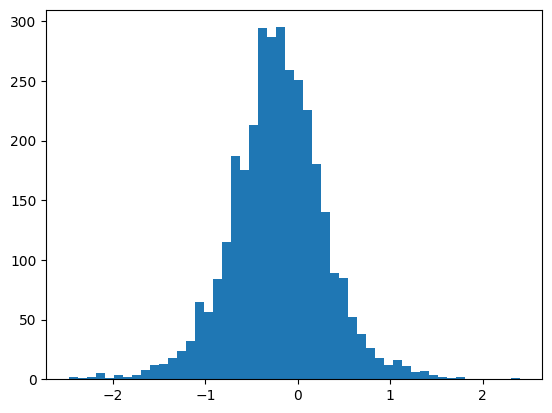

In [ ]:
plt.hist(all_resilience_index, bins=50)

In [ ]:
torch.save(model.state_dict(), "../checkpoints/Feb14_heat_model_bnn_linear_svd_with_heat_bias_variational.pth")

### Shapley Analysis

In [ ]:
import shap
import matplotlib.pyplot as plt
shap.initjs()

In [ ]:
model_name = "Feb14_heat_model_bnn_linear_svd_with_heat_bias_variational"

In [ ]:
interaction_var_size = interaction_vars_np.shape[1]
controlled_var_size = controlled_vars_np.shape[1]
hidden_layer_sizes = [50, 10, 1]
model_index = IndexPredictionModel(interaction_var_size, hidden_layer_sizes, 
                             svd=True, svd_matrix=V.cuda(), k_dim=k_dim)

In [ ]:
state_dict = torch.load('../checkpoints/{}.pth'.format(model_name))
state_dict_index = get_index_prediction_weights(state_dict)
model_index.load_state_dict(state_dict_index)
model_index.cuda().eval()

IndexPredictionModel(
  (layers): ModuleList(
    (0): Linear(in_features=28, out_features=50, bias=True)
    (1): Linear(in_features=50, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=1, bias=True)
  )
)

In [ ]:
interaction_vars_torch = torch.from_numpy(interaction_vars_np.astype('float32')).cuda()
explainer = shap.DeepExplainer(model_index, interaction_vars_torch)

In [ ]:
shap_values = explainer.shap_values(interaction_vars_torch[:1000], check_additivity=False)

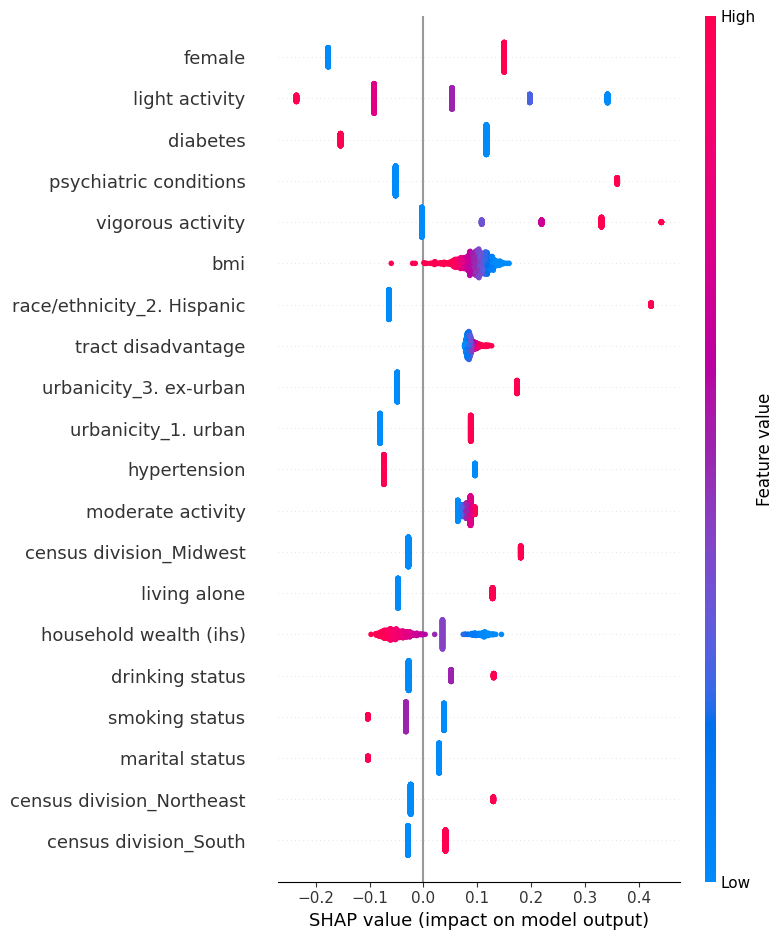

In [ ]:
shap.summary_plot(shap_values[:, :], interaction_vars_torch[:1000, :].detach().cpu().numpy(), feature_names=interaction_predictors, show=False)
plt.savefig("../figures/{}_1.png".format(model_name), dpi=300, bbox_inches="tight")

In [ ]:
state_dict = torch.load('../checkpoints/{}.pth'.format(model_name))
print(state_dict.keys())

odict_keys(['layers.0.weight', 'layers.0.bias', 'layers.1.weight', 'layers.1.bias', 'layers.2.weight', 'layers.2.bias'])
